## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [1]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [2]:
# your code here
Data1['Values'] = np.log(Data1['AvgDailyTrafficCount']) - np.log(Data1['AvgDailyTrafficCount']).mean()

import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared


X = Data1.iloc[:,:2]
y = Data1.Values


In [3]:
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))
gpc_rbf = GaussianProcessRegressor(kernel=kernel, random_state=999).fit(X, y)
print(gpc_rbf.kernel_)
print (gpc_rbf.log_marginal_likelihood_value_)

0.662**2 * RBF(length_scale=0.0355) + WhiteKernel(noise_level=0.567)
-1365.9466919139338


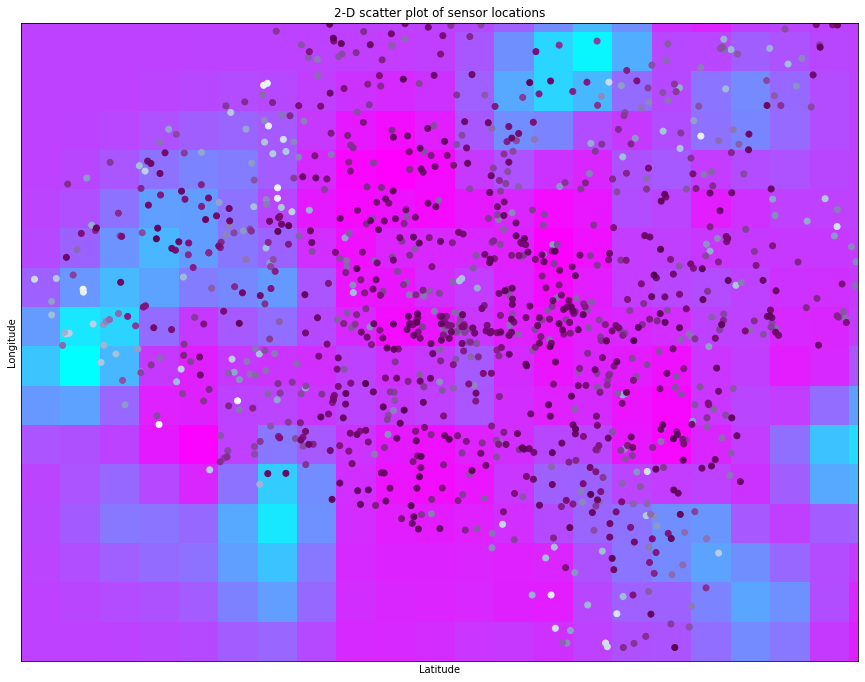

In [4]:
X_1 = np.array(X)
y_1 = np.array(y)

h = .03
x_min, x_max = X_1[:, 0].min() - 0.01, X_1[:, 0].max() + 0.01
y_min, y_max = X_1[:, 1].min() - 0.01, X_1[:, 1].max() + 0.01

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(15, 15))
plt.subplot(1, 1, 1)
Z = gpc_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max),cmap='cool', origin="upper")

plt.scatter(X_1[:, 0], X_1[:, 1], c=y_1, cmap ='BuPu')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("2-D scatter plot of sensor locations")
plt.show()

In [5]:
Data1['Predicted'] = gpc_rbf.predict(Data1[['Longitude', 'Latitude']])
print(Data1['Predicted'])

0      -1.594040
1      -0.800837
2      -1.246781
3      -1.251590
4      -1.326580
          ...   
1110    0.643046
1111    0.491972
1112    0.537111
1113    0.302152
1114    0.627092
Name: Predicted, Length: 1115, dtype: float64


In [6]:
Data1['Score'] = (Data1['Values'] - Data1['Predicted'].mean())/Data1['Predicted'].std()
print(Data1['Score'])
Anomalies = Data1[abs((Data1['Values'] - Data1['Predicted'].mean())/Data1['Predicted'].std()) > 2.0]

0      -7.553064
1      -7.319832
2      -7.280345
3      -7.024826
4      -6.799699
          ...   
1110    2.064087
1111    2.103892
1112    2.118897
1113    2.166291
1114    2.260086
Name: Score, Length: 1115, dtype: float64


In [7]:
p_c = 100*(len(Anomalies)) /(len(Data1))
print ("Percentage of Sensors = ", p_c)

Percentage of Sensors =  13.452914798206278


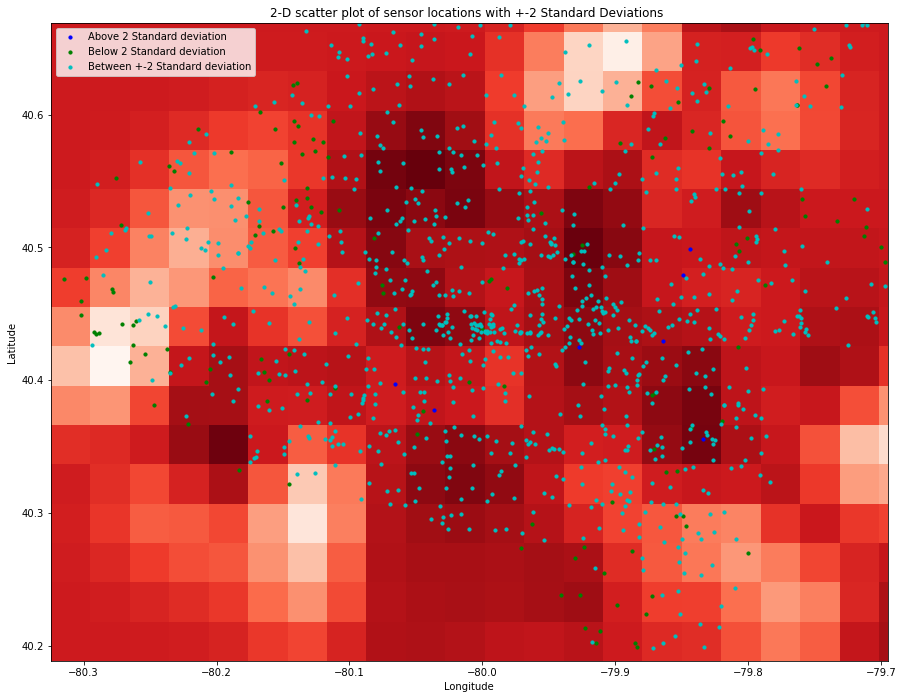

In [8]:
above_std= Data1[Data1['Score'] > 2.0]
below_std = Data1[Data1['Score'] < -2.0]
between_std = Data1[abs(Data1['Score']) <= 2.0]
h = 0.03
X_2 = np.array(X)
y_2 = np.array(y)

x_min, x_max = X_2[:, 0].min() - 0.01, X_2[:, 0].max() + 0.01
y_min, y_max = X_2[:, 1].min() - 0.01, X_2[:, 1].max() + 0.01

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = gpc_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(len(np.arange(y_min, y_max, h)),len(np.arange(x_min, x_max, h)))

plt.figure(figsize=(15, 15))
plt.subplot(1, 1, 1)

plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), cmap='Reds', origin="upper")

plt.scatter(above_std['Longitude'], above_std['Latitude'], c='b', label="Above 2 Standard deviation", s=10)
plt.scatter(below_std['Longitude'], below_std['Latitude'], c='g', label="Below 2 Standard deviation", s=10)
plt.scatter(between_std['Longitude'], between_std['Latitude'], c='c', label="Between +-2 Standard deviation", s=10)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.legend()
plt.title("2-D scatter plot of sensor locations with +-2 Standard Deviations ")
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 2 points, center (10, 10), standard deviation 1

B: 200 points, center (15, 20), standard deviation 1

C: 150 points, center (35, 5), standard deviation 5

D: 100 points, center (0, 0), standard deviation 0.1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(10, 11)	Anomaly / Not Anomaly

(15, 19)	Anomaly / Not Anomaly

(35, 2)		Anomaly / Not Anomaly

(1, 0)		Anomaly / Not Anomaly

### Your solutions here
1. Not Anomaly
Std Deviation is 1 and the point falls within the buffer of 1

2. Not Anomaly
Std Deviation is 1 and the point falls within the buffer of 1

3. Not Anomaly
Std Deviation is 5 and the point falls within the buffer of 5 

4. Anomaly
Std Deviation is 0.1 and the point does not fall within the buffer of 0.1

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [9]:
Data2=pd.read_csv("2022CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','\% Low birth weight births','\% Smokers','\% Obese','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",20,10.0,20,35,32,63.0,16,32.0,578.1,...,15.0,5.1,28.0,12.9,272.0,69.0,9.5,15,87.0,41
1,"Baldwin, Alabama",17,8.0,20,30,28,75.0,22,32.0,336.0,...,12.0,4.4,18.0,10.1,204.0,75.0,7.2,12,83.0,38
2,"Barbour, Alabama",31,12.0,28,40,42,50.0,14,38.0,895.2,...,38.0,6.0,54.0,7.3,414.0,82.0,9.0,15,84.0,37
3,"Bibb, Alabama",25,10.0,25,41,38,11.0,16,21.0,540.3,...,22.0,5.4,37.0,8.9,89.0,103.0,9.4,11,88.0,55
4,"Blount, Alabama",23,8.0,22,39,33,23.0,16,15.0,404.7,...,19.0,4.8,23.0,7.4,483.0,105.0,9.4,10,88.0,60


In [10]:
Data2.columns

Index(['County', ''\% Reporting Fair/Poor Health'',
       ''\% Low birth weight births'', ''\% Smokers'', ''\% Obese'',
       ''\% Physically Inactive'', ''\% With Access To Exercise'',
       ''\% Excessive Drinking'', ''\% Alcohol-Impaired Driving Deaths'',
       ''Chlamydia Rate'', ''Teen Birth Rate'', ''\% Uninsured'',
       ''Preventable Hosp. Rate'', ''\% Mammography'', ''Graduation Rate'',
       ''\% Some College'', ''\% Unemployed'', ''\% Children in Poverty'',
       ''80/20 Income Ratio'', ''\% Single-Parent Households'',
       ''Association Rate'', ''Violent Crime Rate'', ''Injury Death Rate'',
       ''Average Daily PM2.5'', ''\% Severe Housing Problems'',
       ''\% Drive Alone'', ''\% Long Commute - Drives Alone''],
      dtype='object')

In [11]:
Data2_s = Data2[["'\% Smokers'","'\% Obese'",\
       "'Violent Crime Rate'", "'80/20 Income Ratio'", \
       "'\% Children in Poverty'", "'Average Daily PM2.5'"]]
Data2_s.iloc[:,0:] = Data2_s.iloc[:,0:].apply(pd.cut, bins=5, labels=False)
Data2_s.dropna(axis = 0, inplace = True)
Data2_s

C:\Users\Shantanu\anaconda3\lib\site-packages\pandas\core\indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
<ipython-input-11-0167001f8fb5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2_s.dropna(axis = 0, inplace = True)


,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,1,2,0.0,2.0,1.0,1.0
1,1,1,0.0,1.0,0.0,1.0
2,2,3,1.0,2.0,3.0,1.0
3,2,3,0.0,2.0,1.0,1.0
4,2,3,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...
3136,1,1,0.0,2.0,0.0,0.0
3137,1,2,0.0,1.0,0.0,0.0
3139,1,1,0.0,1.0,0.0,1.0
3140,1,1,0.0,1.0,0.0,0.0


In [12]:
Data2_s.iloc[:,0:] = Data2_s.iloc[:,0:].apply(pd.to_numeric,errors='coerce',downcast='integer')

Data2_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2934 entries, 0 to 3141
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   '\% Smokers'              2934 non-null   int8 
 1   '\% Obese'                2934 non-null   int8 
 2   'Violent Crime Rate'      2934 non-null   int8 
 3   '80/20 Income Ratio'      2934 non-null   int8 
 4   '\% Children in Poverty'  2934 non-null   int8 
 5   'Average Daily PM2.5'     2934 non-null   int8 
dtypes: int8(6)
memory usage: 40.1 KB


C:\Users\Shantanu\anaconda3\lib\site-packages\pandas\core\indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [13]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
hc = HillClimbSearch(Data2_s)
hc_model = hc.estimate(scoring_method='bicscore')
print(hc_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[("'\\% Smokers'", "'\\% Children in Poverty'"), ("'\\% Smokers'", "'Average Daily PM2.5'"), ("'\\% Obese'", "'\\% Smokers'"), ("'\\% Children in Poverty'", "'80/20 Income Ratio'"), ("'\\% Children in Poverty'", "'Violent Crime Rate'")]


In [14]:
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print (thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

In [15]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest

In [16]:
bayes_model = BayesianModel(hc_model.edges())
bayes_model.fit(Data2_s, estimator=MaximumLikelihoodEstimator)
Data2_s['loglikelihood']=Data2_s.iloc[:,:].apply(lambda x: LL(x, bayes_model, verbose = False),axis=1)


C:\Users\Shantanu\anaconda3\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(
<ipython-input-16-3f706e1d4733>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2_s['loglikelihood']=Data2_s.iloc[:,:].apply(lambda x: LL(x, bayes_model, verbose = False),axis=1)


In [17]:
Data2_s

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5',loglikelihood
0,1,2,0,2,1,1,-3.703963
1,1,1,0,1,0,1,-3.952206
2,2,3,1,2,3,1,-6.486806
3,2,3,0,2,1,1,-3.925438
4,2,3,1,1,1,1,-4.121609
...,...,...,...,...,...,...,...
3136,1,1,0,2,0,0,-7.907874
3137,1,2,0,1,0,0,-3.692714
3139,1,1,0,1,0,1,-3.952206
3140,1,1,0,1,0,0,-5.431552


In [18]:
Data2_s.sort_values(by= ["loglikelihood"], ascending = True).head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5',loglikelihood
2653,2,3,2,0,0,2,-17.083439
319,0,1,3,3,1,1,-16.698151
1858,0,0,1,4,1,2,-16.574772
1229,0,1,2,3,1,2,-16.005004
195,0,3,1,2,1,3,-15.809304


In [19]:
Data2.columns

Index(['County', ''\% Reporting Fair/Poor Health'',
       ''\% Low birth weight births'', ''\% Smokers'', ''\% Obese'',
       ''\% Physically Inactive'', ''\% With Access To Exercise'',
       ''\% Excessive Drinking'', ''\% Alcohol-Impaired Driving Deaths'',
       ''Chlamydia Rate'', ''Teen Birth Rate'', ''\% Uninsured'',
       ''Preventable Hosp. Rate'', ''\% Mammography'', ''Graduation Rate'',
       ''\% Some College'', ''\% Unemployed'', ''\% Children in Poverty'',
       ''80/20 Income Ratio'', ''\% Single-Parent Households'',
       ''Association Rate'', ''Violent Crime Rate'', ''Injury Death Rate'',
       ''Average Daily PM2.5'', ''\% Severe Housing Problems'',
       ''\% Drive Alone'', ''\% Long Commute - Drives Alone''],
      dtype='object')

In [20]:
Data2.iloc[[2653,319,1858,1229,195],[0,3,4,17,18,21,23,]]

,County,'\% Smokers','\% Obese','\% Children in Poverty','80/20 Income Ratio','Violent Crime Rate','Average Daily PM2.5'
2653,"Kenedy, Texas",25,44,14.0,2.8,978.0,10.3
319,"District of Columbia, District of Columbia",14,28,22.0,6.8,1226.0,9.5
1858,"New York, New York",11,22,19.0,9.1,586.0,10.4
1229,"Suffolk, Massachusetts",13,25,21.0,7.7,752.0,10.2
195,"Fresno, California",14,38,23.0,5.1,542.0,17.1


In [21]:
from sklearn.cluster import KMeans
Data_k_m = Data2.copy().dropna()
KM=KMeans(n_clusters=3,random_state=999)
KM.fit(Data_k_m.iloc[:,1:])
res=pd.DataFrame(KM.transform(Data_k_m.iloc[:,1:]))
Data_k_m.iloc[:,1:] = Data_k_m.iloc[:,1:].apply(pd.to_numeric,errors='coerce',downcast='integer')
Data_k_m = Data_k_m.dropna()
res_k_m=pd.DataFrame(KM.transform(Data_k_m.iloc[:,1:]))
res_k_m.index = Data_k_m.index
res_k_m.columns=list(range(3))
False
from sklearn.cluster import KMeans
res_k_m["nearest"] = res_k_m.min(axis=1)
res_k_m['cluster_type'] = res_k_m.idxmin(axis=1)
res_k_m.sort_values(by= ["nearest"], ascending= False).head(5)

,0,1,2,nearest,cluster_type
3021,11453.986474,9656.503824,7074.819206,7074.819206,2
1130,9700.672401,7899.496436,5348.139988,5348.139988,2
3014,9455.431343,7658.731735,5081.833598,5081.833598,2
1078,9316.426374,7522.914946,4945.404395,4945.404395,2
1123,8720.778899,6921.372379,4338.603171,4338.603171,2


In [22]:
Data2.iloc[[3021,1130,3014,1078,1123],[0,3,4,17,18,21,23,]]


,County,'\% Smokers','\% Obese','\% Children in Poverty','80/20 Income Ratio','Violent Crime Rate','Average Daily PM2.5'
3021,"Mingo, West Virginia",30,47,30.0,5.8,282.0,7.9
1130,"East Carroll, Louisiana",33,48,51.0,8.3,640.0,8.8
3014,"Logan, West Virginia",29,45,29.0,6.3,558.0,7.9
1078,"Monroe, Kentucky",29,38,32.0,6.8,29.0,8.0
1123,"Caldwell, Louisiana",27,39,29.0,6.5,221.0,9.1


In [23]:
Data_gm = Data2.copy().dropna()
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(Data_gm.iloc[:,1:])
res_gm=pd.DataFrame()
res_gm["loglikelihood"] = GM.score_samples(Data_gm.iloc[:,1:])
res_gm.index = Data_gm.index
res_gm.sort_values(by= ["loglikelihood"],ascending = True).head()

,loglikelihood
2080,-140.117214
1858,-131.514797
2711,-130.565032
2032,-127.262833
1813,-126.361536


In [24]:
Data2.iloc[[2080,1858,2711,2032,1813],[0,3,4,17,18,21,23,]]

,County,'\% Smokers','\% Obese','\% Children in Poverty','80/20 Income Ratio','Violent Crime Rate','Average Daily PM2.5'
2080,"Holmes, Ohio",29,36,12.0,3.7,21.0,9.0
1858,"New York, New York",11,22,19.0,9.1,586.0,10.4
2711,"Presidio, Texas",21,45,32.0,5.6,87.0,5.8
2032,"Sioux, North Dakota",34,49,33.0,5.7,11.0,5.9
1813,"Mora, New Mexico",14,33,26.0,5.1,120.0,4.5


In [25]:
Data_clf = Data2.copy().dropna()
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(Data_clf.iloc[:,1:])
res_clf = pd.DataFrame()
res_clf['score'] = clf.decision_function(Data_clf.iloc[:,1:])
res_clf.index = Data_clf.index
res_clf.sort_values(by= ["score"]).head()

,score
1130,-0.147714
2711,-0.130694
2032,-0.128215
2736,-0.118213
2775,-0.117587


In [26]:
Data2.iloc[[1130,2711,2032,2736,2775],[0,3,4,17,18,21,23,]]

,County,'\% Smokers','\% Obese','\% Children in Poverty','80/20 Income Ratio','Violent Crime Rate','Average Daily PM2.5'
1130,"East Carroll, Louisiana",33,48,51.0,8.3,640.0,8.8
2711,"Presidio, Texas",21,45,32.0,5.6,87.0,5.8
2032,"Sioux, North Dakota",34,49,33.0,5.7,11.0,5.9
2736,"Starr, Texas",21,47,35.0,5.7,263.0,11.0
2775,"Zapata, Texas",19,43,40.0,6.5,96.0,10.2
